# Visualization for Faster R-CNN models

In [17]:
import torch
import torchvision
from data.labeled_dataset import LabeledDataset
from utils.resize_with_aspect import resize_with_aspect
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNet18_Weights
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np

In [2]:
UATD_PATH = input("Please enter the path to a UATD-dataset: ")

In [ ]:
MODEL_PATHS = {
    "faster_rcnn_100pct": "/home/yoran/bap-2425-yorangyselen/poc/models/faster_rcnn_100/faster_rcnn_100_20250508_165016.pth",
    "faster_rcnn_50pct": "/home/yoran/bap-2425-yorangyselen/poc/models/faster_rcnn_50/faster_rcnn_50_20250513_120841.pth",
    "faster_rcnn_10pct": "/home/yoran/bap-2425-yorangyselen/poc/models/faster_rcnn_10/faster_rcnn_10_20250513_114551.pth",
    "faster_rcnn_5pct": "/home/yoran/bap-2425-yorangyselen/poc/models/faster_rcnn_5/faster_rcnn_5_20250513_115733.pth",
    "faster_rcnn_1pct": "/home/yoran/bap-2425-yorangyselen/poc/models/faster_rcnn_1/faster_rcnn_1_20250513_120427.pth"
}

In [ ]:
ID = int(input("Please enter the ID of the image you want to evaluate: "))

In [25]:
NUM_CLASSES = 11

LABEL_MAP = [
    "__background__", "cube", "ball", "cylinder", "human body",
    "tyre", "square cage", "plane",
    "rov", "circle cage", "metal bucket"
]

In [5]:
dataset = LabeledDataset(
    os.path.join(UATD_PATH, "images"),
    os.path.join(UATD_PATH, "annotations"),
    transforms=resize_with_aspect,
)

In [6]:
image_tensor, true_target = dataset.__getitem__(idx=ID)

In [15]:
def load_model(model_path, device):
    backbone = resnet_fpn_backbone(backbone_name="resnet18", weights=ResNet18_Weights.DEFAULT)
    model = FasterRCNN(backbone, num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [28]:
def draw_boxes(image, outputs, score_threshold=0.5):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    boxes = outputs['boxes']
    scores = outputs['scores']
    labels = outputs['labels']

    for box, score, label in zip(boxes, scores, labels):
        if score >= score_threshold:
            box = box.tolist()
            label_text = LABEL_MAP[label.item()] if LABEL_MAP else str(label.item())
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1] - 15), f"{label_text} ({score*100:.2f}%)", fill="red", font=font)

    return image

In [ ]:
def draw_ground_truth(image, ground_truth, label_names=None):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    gt_boxes = ground_truth['boxes']
    gt_labels = ground_truth['labels']

    for box, label in zip(gt_boxes, gt_labels):
        box = box.tolist()
        label_text = label_names[label.item()] if label_names else str(label.item())
        draw.rectangle(box, outline="green", width=2)
        draw.text((box[0], box[1] - 15), label_text, fill="green", font=font)

    return image

In [ ]:
def draw_predictions(image, outputs, label_names=None, score_threshold=0.5):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    boxes = outputs['boxes']
    scores = outputs['scores']
    labels = outputs['labels']

    for box, score, label in zip(boxes, scores, labels):
        if score >= score_threshold:
            box = box.tolist()
            label_text = label_names[label.item()] if label_names else str(label.item())
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1] - 15), f"{label_text} ({score*100:.2f}%)", fill="red", font=font)

    return image

In [ ]:
def save_individual_model_visualizations(image_tensor, model_paths, ground_truth, label_names=None,
                                         output_dir="separate_results", device="cpu", score_threshold=0.5):
    os.makedirs(output_dir, exist_ok=True)

    image_orig = F.to_pil_image(image_tensor)

    # Save Ground Truth image
    gt_img = draw_ground_truth(image_orig, ground_truth, label_names)
    gt_path = Path(output_dir) / f"{ID}_gt.jpg"
    gt_img.save(gt_path)
    print(f"Saved ground truth image to {gt_path}")

    # Save each model's prediction image
    for model_name, model_path in model_paths.items():
        print(f"Running model: {model_name}")
        model = load_model(model_path, device)
        with torch.no_grad():
            outputs = model([image_tensor.to(device)])[0]

        pred_img = draw_predictions(image_orig, outputs, label_names, score_threshold=score_threshold)
        pred_path = os.path.join(Path(output_dir), f"{ID}_{model_name}.png")
        pred_img.save(pred_path)
        print(f"Saved prediction image for '{model_name}' to {pred_path}")

Processing with model: faster_rcnn_100_20250508_165016


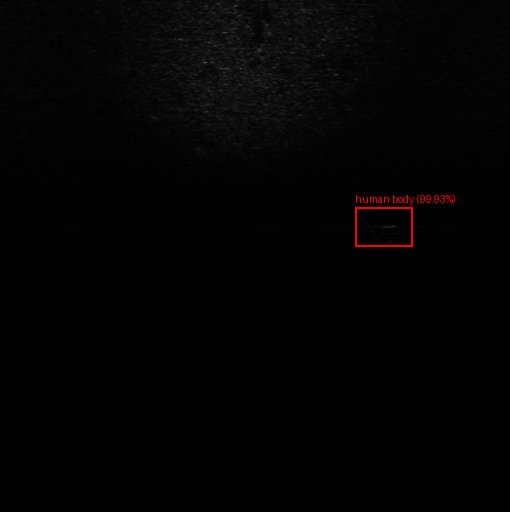

In [29]:
visualize_models_on_image(image_tensor=image_tensor, model_path=MODEL_PATH, output_dir="results", device="cuda" if torch.cuda.is_available() else "cpu")